# XGBoost Municipios Norte del Cuca

In [2]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install xgboost


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb

In [43]:
path = 'dataset/datasetFinalTesisValle_NCauca.csv'
data = pd.read_csv(path)


Si se desea correr para 

76 => Valle del Cauca 

19 => Cauca

ó para todos quitar la condicion


In [44]:
#df = data.dropna(subset=['clasificacion_letter'])
df = data.loc[data['cod_dpto'] == 19].dropna(subset=['clasificacion_letter'])

In [45]:
print(df.head(3))

label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df['clasificacion_letter_numeric'] = df['clasificacion_letter'].map(label_mapping)
df= df.drop(columns=['clasificacion_letter'])
df['nombre_columna'] = df['clasificacion_letter_numeric'].astype(int)
print(df.head(3))

    cod_dpto  cod_mpio  cod_clase  cod_barrio  cod_vereda  cod_corregimiento  \
0         19     19455          2           0         333                  0   
11        19     19780          1         212           0                  0   
95        19     19110          3           0           0                  2   

    cod_comuna  tot_viviendas  tot_hogares  tip_vivienda  ...  ind_estudia  \
0           99              0            1             3  ...            9   
11          99              0            1             1  ...            9   
95          99              0            1             1  ...            9   

    clasificacion_letter  sum_gastos  sum_ingresos  ide_ficha_origen_hogar  \
0                      A           0             0  19455915512800003130-1   
11                     A           0             0  19780009530500000012-1   
95                     B      105000             0  19110273542300000457-1   

    max_nivel_educativo_en_hogar  alguien_hogar_emple

# Normalizar Columnas no Categoricas

In [46]:
# 'ind_evento_avalancha','ind_evento_inundacion'

X = df[
    ['edad_calculada','cod_dpto', 'cod_mpio', 'cod_clase', 'cod_barrio', 'cod_vereda', 'cod_corregimiento', 'cod_comuna', 'tip_vivienda',
     'tip_mat_paredes', 'tip_mat_pisos', 'ind_tiene_energia', 'ind_tiene_gas', 'num_cuartos_exclusivos',
     'num_cuartos_unicos_dormir', 'tip_sanitario', 'tip_uso_sanitario', 'tip_origen_agua', 'tip_uso_agua_beber',
     'ind_tiene_cocina', 'tip_prepara_alimentos', 'tip_uso_cocina', 'tip_energia_cocina',
      'num_personas_hogar', 'num_habita_vivienda', 'ind_tiene_internet',
     'max_nivel_educativo_en_hogar', 'alguien_hogar_empleado_o_similar', 'alguien_hogar_cotiza_pension',
     'sum_ingresos_hogar', 'sum_gastos_hogar']]
y = df['clasificacion_letter_numeric']


In [47]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df.head(3)
columns_to_normalize = ['sum_ingresos_hogar', 'sum_gastos_hogar']

normalized_values = scaler.fit_transform(X[columns_to_normalize])

X[columns_to_normalize]= normalized_values



/var/folders/vh/c65wsrm94x92d8rfk33vvpwr0000gn/T/ipykernel_48056/308799156.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[columns_to_normalize]= normalized_values


## Division de datos con columnas seleccionadas

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##  Creacion del Modelo Base y busqueda de mejores Estimadores e HiperParametros

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejor número de estimadores: 200
Mejor puntuación: 0.87400015839075


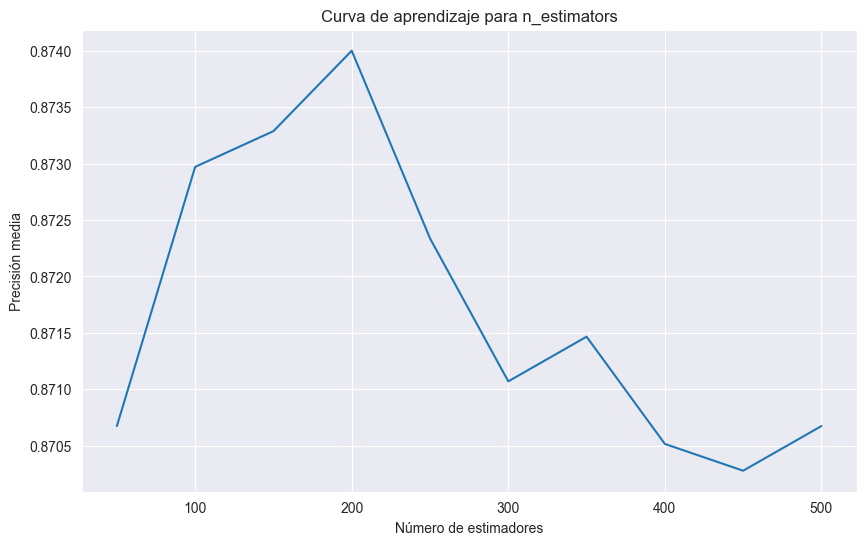

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.8}
Mejor puntuación: 0.8751088936406113
Puntuación en el conjunto de prueba: 0.8797035347776511


In [49]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV


model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42, tree_method='hist')

param_grid = {
    'n_estimators': range(50, 550, 50)
}


cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(accuracy_score),
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train, y_train)

print("Mejor número de estimadores:", grid_search.best_params_['n_estimators'])
print("Mejor puntuación:", grid_search.best_score_)


results = grid_search.cv_results_
plt.figure(figsize=(10, 6))
plt.plot(param_grid['n_estimators'], results['mean_test_score'])
plt.xlabel('Número de estimadores')
plt.ylabel('Precisión media')
plt.title('Curva de aprendizaje para n_estimators')
plt.show()


best_n_estimators = grid_search.best_params_['n_estimators']


param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, n_estimators=best_n_estimators, 
                          random_state=42, tree_method='hist')

# Configuramos GridSearchCV para los otros parámetros
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(accuracy_score),
    n_jobs=-1,
    verbose=2
)

# Realizamos la búsqueda
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

# Evaluamos el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Puntuación en el conjunto de prueba:", test_score)

# Mejor Modelo ajustado

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9497742931812783

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     14502
           1       0.92      0.82      0.87      4111
           2       0.96      0.93      0.94      2309
           3       1.00      0.97      0.98       123

    accuracy                           0.95     21045
   macro avg       0.96      0.93      0.94     21045
weighted avg       0.95      0.95      0.95     21045


Resultados en el conjunto de prueba:
Accuracy: 0.8797035347776511

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3619
           1       0.73      0.67      0.70      1024
           2       0.79      0.76      0.78       582
           3       0.75      0.32      0.45        37

    accuracy                           0.88      5262
   macro avg       0.80      0.68      0.72      52

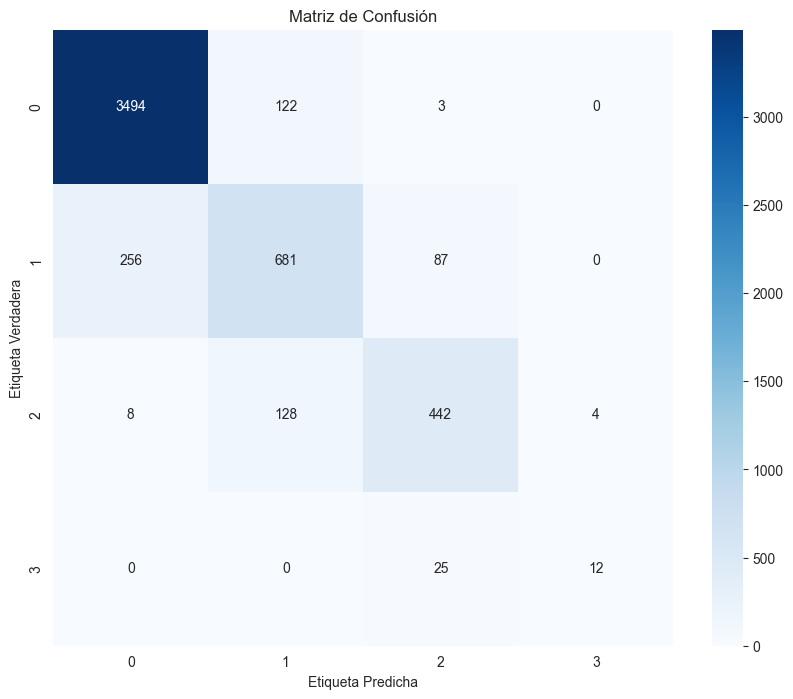

<Figure size 1000x800 with 0 Axes>

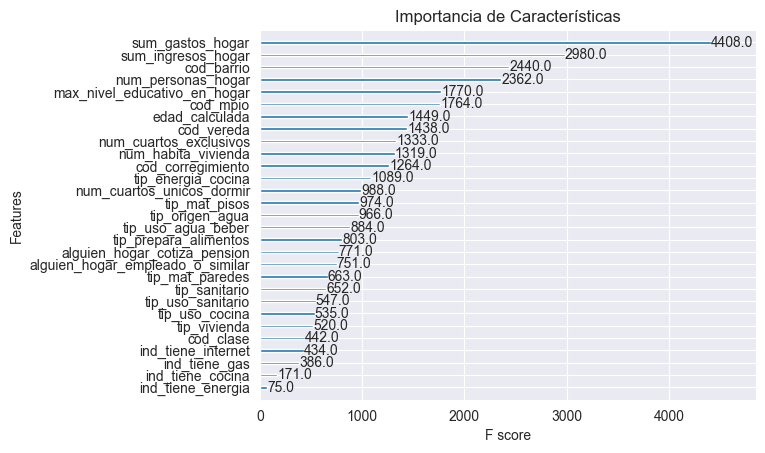

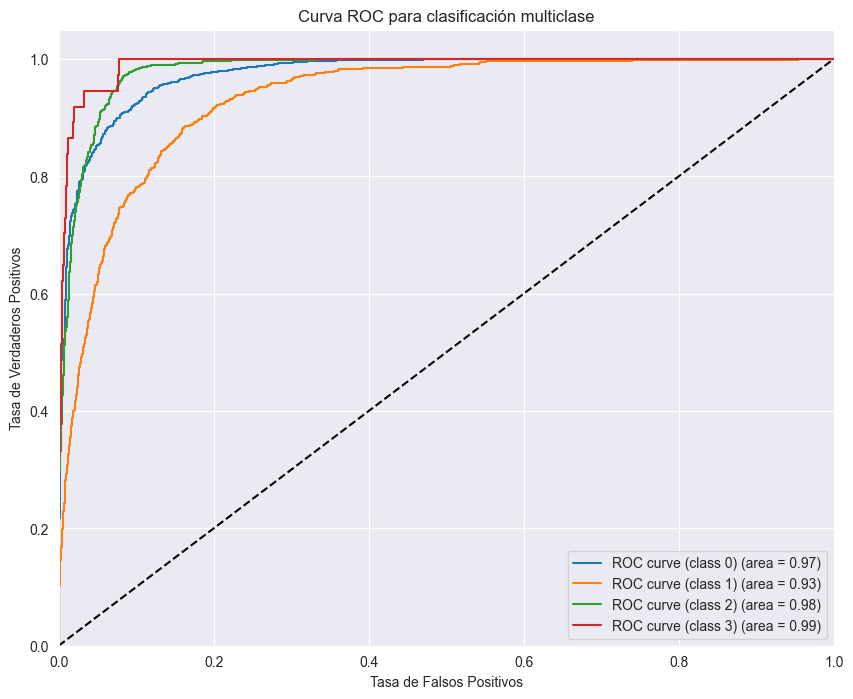

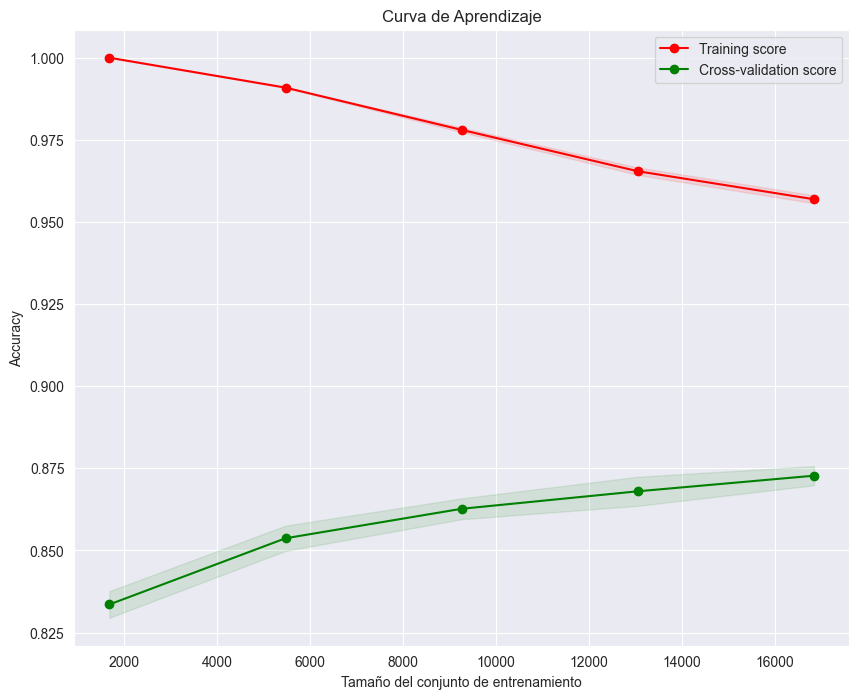

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

best_model = grid_search.best_estimator_


best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


print("Resultados en el conjunto de entrenamiento:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred)}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

print("\nResultados en el conjunto de prueba:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()


plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model)
plt.title('Importancia de Características')
plt.show()


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = best_model.predict_proba(X_test)

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para clasificación multiclase')
plt.legend(loc="lower right")
plt.show()

# 6. Curva de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Curva de Aprendizaje")
plt.legend(loc="best")
plt.show()

## Validacion Cruzada K-fold

In [52]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X, y, cv=5)
print(f"Puntuaciones de validación cruzada: {cv_scores}")
print(f"Media de validación cruzada: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Puntuaciones de validación cruzada: [0.86982136 0.87400228 0.87283786 0.87625927 0.8673256 ]
Media de validación cruzada: 0.8720 (+/- 0.0063)


## Curva de Precision Recall

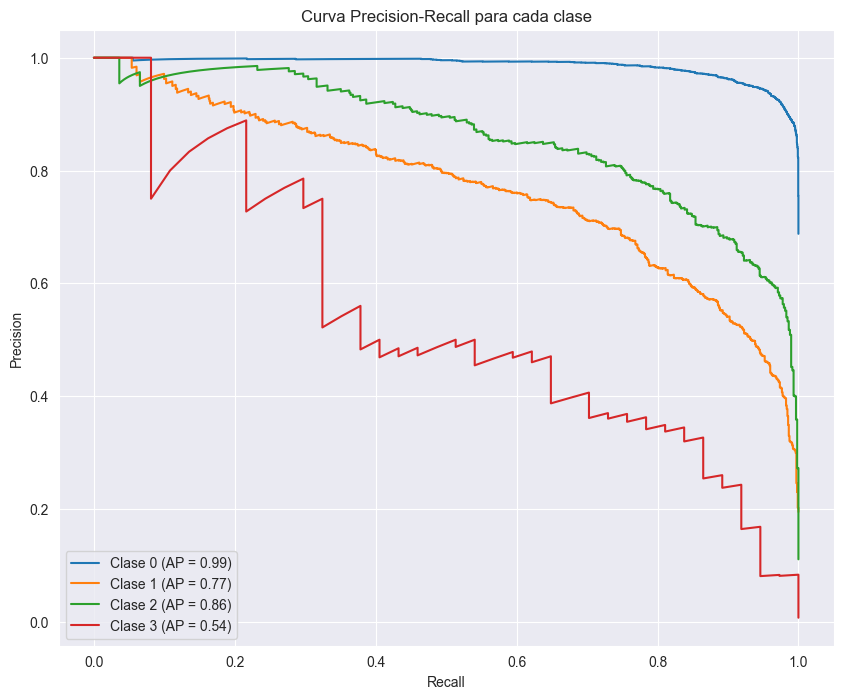

In [53]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = best_model.predict_proba(X_test)

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Clase {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para cada clase')
plt.legend()
plt.show()

## Calibracion del Modelo

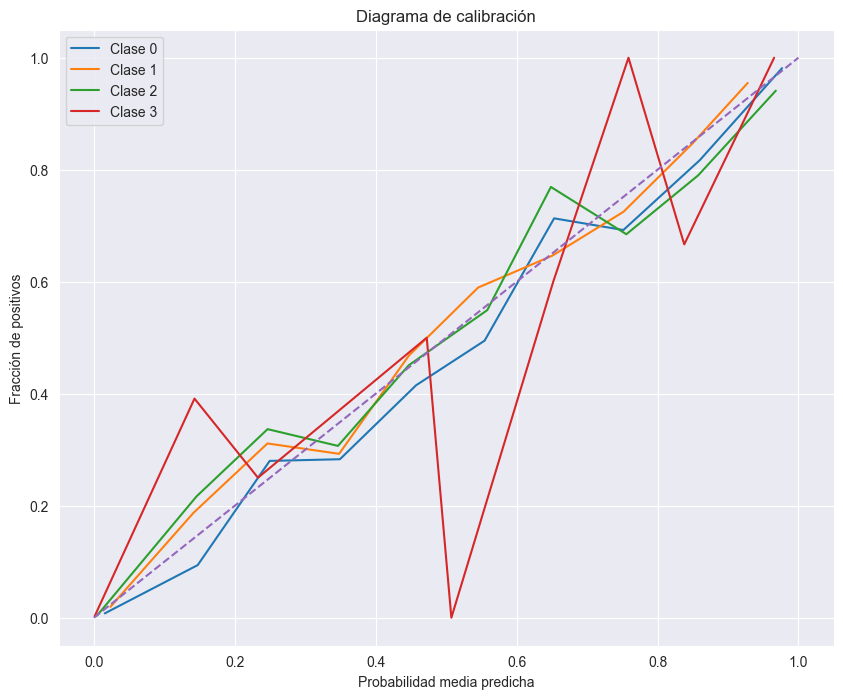

In [56]:
####
from sklearn.calibration import calibration_curve
n_classes=4
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    prob_true, prob_pred = calibration_curve(y_test_bin[:, i], y_score[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, label=f'Clase {i}')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Probabilidad media predicha')
plt.ylabel('Fracción de positivos')
plt.title('Diagrama de calibración')
plt.legend()
plt.show()

## Curva de ganancia acumulativa y curva de elevación:

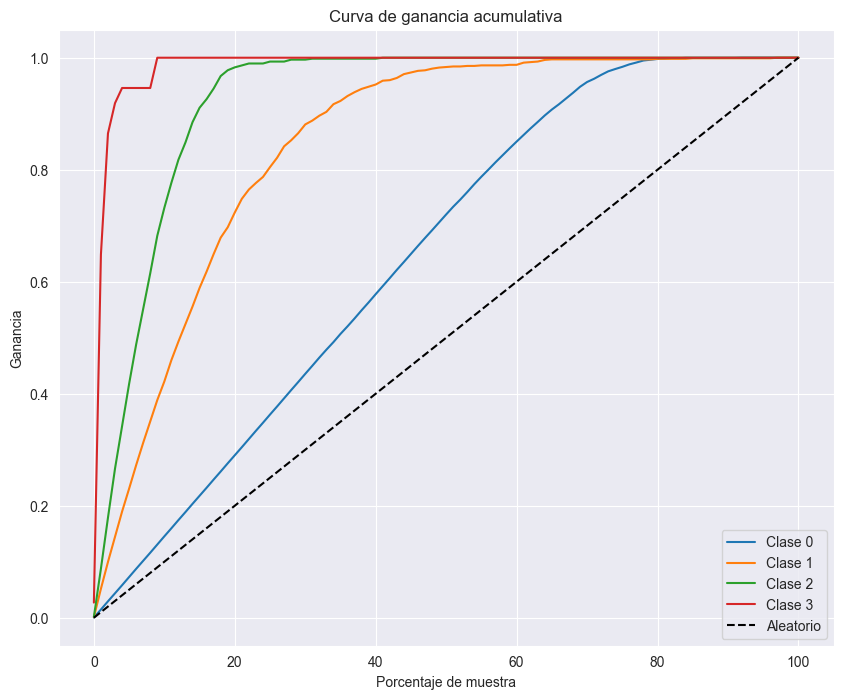

In [58]:
from sklearn.metrics import roc_auc_score

def plot_cumulative_gain(y_true, y_score, title='Curva de ganancia acumulativa'):
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        y_true_class = y_true_bin[:, i]
        y_score_class = y_score[:, i]
        
        percentages = np.arange(0, 101, 1)
        gains = []
        
        for percent in percentages:
            threshold = np.percentile(y_score_class, 100 - percent)
            y_pred = (y_score_class >= threshold).astype(int)
            gains.append(np.sum(y_true_class * y_pred) / np.sum(y_true_class))
        
        plt.plot(percentages, gains, label=f'Clase {i}')

    plt.plot([0, 100], [0, 1], 'k--', label='Aleatorio')
    plt.xlabel('Porcentaje de muestra')
    plt.ylabel('Ganancia')
    plt.title(title)
    plt.legend()
    plt.show()

plot_cumulative_gain(y_test, y_score)

## Análisis de umbral de decisión:

/Users/wladimiravila/Documents/Models/modelos-infancia/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wladimiravila/Documents/Models/modelos-infancia/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wladimiravila/Documents/Models/modelos-infancia/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

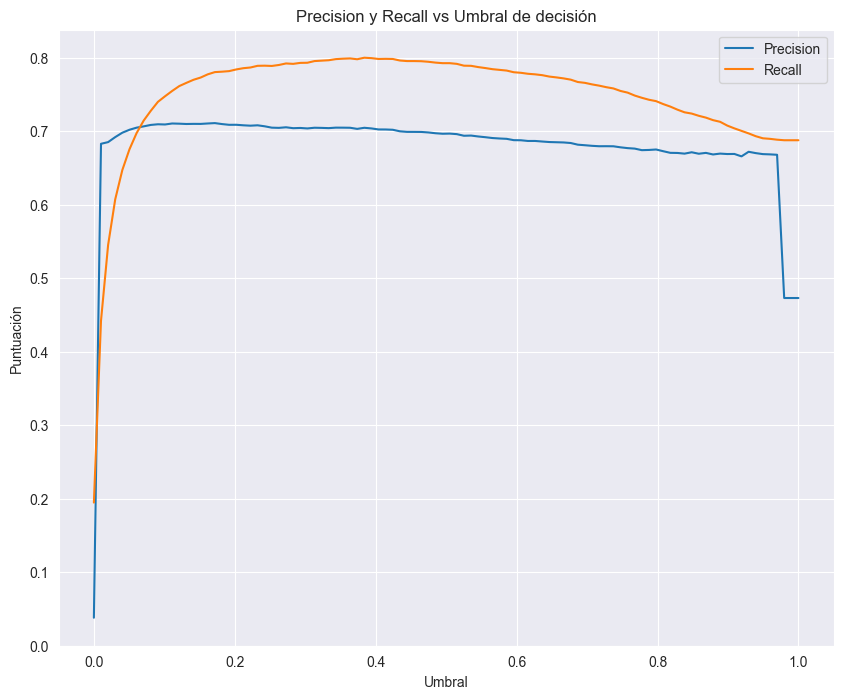

In [59]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (y_score[:, 1] > threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))

plt.figure(figsize=(10, 8))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Umbral')
plt.ylabel('Puntuación')
plt.title('Precision y Recall vs Umbral de decisión')
plt.legend()
plt.show()

## Importancia de Columnas


Notese que la columna cod_dpto cuando se genera el modelo para un departamento en particulariedad no genera importancia y por lo tanto se podria eliminar, caso contrario cuando se mezclan los municipios del norte del Cauca y el Valle del Cauca


Top 10 características más importantes:
                         feature  importance
28              sum_gastos_hogar      4408.0
27            sum_ingresos_hogar      2980.0
3                     cod_barrio      2440.0
21            num_personas_hogar      2362.0
24  max_nivel_educativo_en_hogar      1770.0
1                       cod_mpio      1764.0
0                 edad_calculada      1449.0
4                     cod_vereda      1438.0
11        num_cuartos_exclusivos      1333.0
22           num_habita_vivienda      1319.0


<Figure size 1000x800 with 0 Axes>

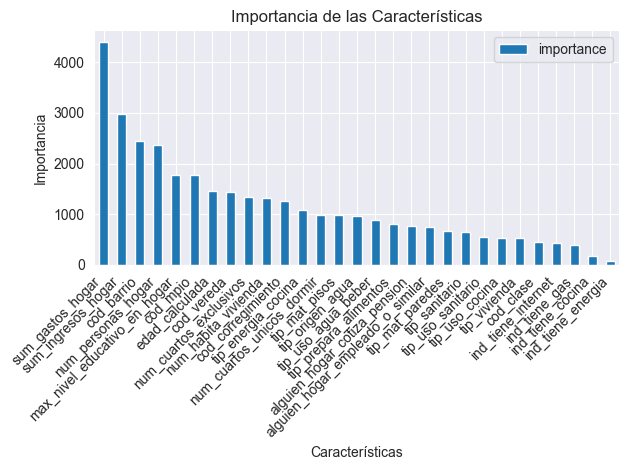


Las 20 características más importantes:
1. sum_gastos_hogar
2. sum_ingresos_hogar
3. cod_barrio
4. num_personas_hogar
5. max_nivel_educativo_en_hogar
6. cod_mpio
7. edad_calculada
8. cod_vereda
9. num_cuartos_exclusivos
10. num_habita_vivienda
11. cod_corregimiento
12. tip_energia_cocina
13. num_cuartos_unicos_dormir
14. tip_mat_pisos
15. tip_origen_agua
16. tip_uso_agua_beber
17. tip_prepara_alimentos
18. alguien_hogar_cotiza_pension
19. alguien_hogar_empleado_o_similar
20. tip_mat_paredes


In [60]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt


importance = best_model.get_booster().get_score(importance_type='weight')


importance_df = pd.DataFrame({'feature': list(importance.keys()),
                              'importance': list(importance.values())})


importance_df = importance_df.sort_values('importance', ascending=False)


print("Top 10 características más importantes:")
print(importance_df.head(10))


plt.figure(figsize=(10, 8))
importance_df.plot(x='feature', y='importance', kind='bar')
plt.title('Importancia de las Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


top_features = importance_df['feature'].head(20).tolist()

print("\nLas 20 características más importantes:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")